In [36]:
from intuitlib.client import AuthClient
from quickbooks import QuickBooks
from quickbooks.objects.account import Account
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar

In [13]:
def proc_rows(rows, category = "", level=0):
    row_list = []
    for row in rows:
        if "Header" in row:
            header_col = row['Header']['ColData'][0]['value']
            if category == "":
                current_category = header_col
            else:
                current_category = f"{category}:{header_col}"
            row_list.extend(proc_rows(row['Rows']['Row'], category = current_category, level = level+1))
        else:
            col_data = row['ColData']
            if len(col_data)==len(cols):
                cur_row = {cols[i]:col_data[i]['value'] for i in range(len(cols))}
                cur_row.update({"category":category})
                cur_row.update({"category_level":level})
                row_list.append(cur_row)
    return row_list

In [14]:
auth_client = AuthClient(
        client_id='ABVlDV6VbSq3SyfN6ShES7gauQ8LExHxnhuoDVsKaEOe3GmBrT',
        client_secret='zqQX950hO9CICCreDvfAvk3mE7tuJJKrGyyrRxEU',
        access_token=None,
        environment='production',
        redirect_uri='https://developer.intuit.com/v2/OAuth2Playground/RedirectUrl',
    )

In [15]:
client = QuickBooks(
        auth_client=auth_client,
        refresh_token='AB11696945575KFtkR4r0sxeC8eke77Nc7AV0zynHM5MDsemjJ',
        company_id='514655250',
    )

In [16]:
# Date information
year = 2023
month = 4
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]

In [17]:
{"start_date":f"{year}-{month}-01", "end_date":f"{year}-{month}-{days}"}

{'start_date': '2023-4-01', 'end_date': '2023-4-30'}

In [18]:
json_resp = client.get_report("ProfitAndLossDetail", {"start_date":f"{year}-{month}-01", "end_date":f"{year}-{month}-{days}"})

In [19]:
cols = [i["ColTitle"] for i in json_resp['Columns']['Column']]
report_info = json_resp['Header']
row_list = proc_rows(json_resp["Rows"]["Row"][0]['Rows']['Row'])

In [38]:
# data manipulation
qbdf = pd.DataFrame(row_list)
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)

budget_map = "../resources/qb_to_budget_map.csv"
budgetdf = pd.read_csv(budget_map)
budget_items = budgetdf['QB_Item'].unique()

expense_types = ["Check","Expense"]
expenses = qbdf.loc[qbdf['Transaction Type'].astype(str).isin(expense_types)]
income = qbdf.loc[qbdf['Transaction Type'] == 'Deposit']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [26]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum"}).reset_index()
all_totals = pd.merge(budgetdf,category_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [39]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()

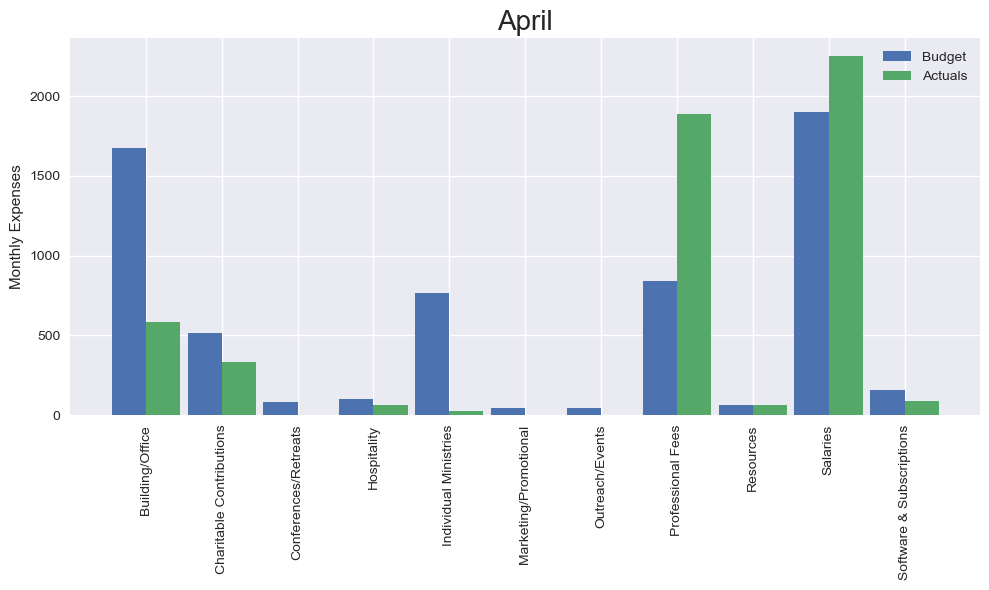

In [37]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90)
plt.tight_layout()

In [172]:
expenses.loc[expenses['item']=='Church Insurance']

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item
18,2023-04-03,Check,,K-Lawn,Snow removal,1002 ENT Checking (Keystone),1712.12,1712.12,Expenses:Facilities:Building/Office:Church Ins...,4,Church Insurance
